<a href="https://colab.research.google.com/github/sxk1031/digital_pathology/blob/main/make_train_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataname="epistroma"

patch_size=500
stride_size=250
mirror_pad_size=500
test_set_size=.1
resize=1
max_patches = int(1E2)
classes=[0,1]

In [3]:
import torch
import tables

import os,sys
import glob

import PIL
import numpy as np

import cv2
import matplotlib.pyplot as plt

from sklearn import model_selection
import sklearn.feature_extraction.image
import random
from matplotlib.figure import Figure

random_state = 42

In [4]:
img_dtype = tables.UInt8Atom()
filenameAtom = tables.StringAtom(itemsize=255)

In [16]:
path = os.getcwd()+'/drive/MyDrive/dl_tutorial/epithelium/epi'
os.chdir('/content/drive/MyDrive/dl_tutorial/epithelium/epi')

In [17]:
def extract_patch(file, interp_method):
  '''
  Reads image file and creates patches based on the interpolation method.
  '''
  img=cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(0,0),fx=resize,fy=resize, interpolation=interp_method) #resize it as specified above
  img = np.pad(img, [(mirror_pad_size, mirror_pad_size), (mirror_pad_size, mirror_pad_size), (0, 0)], mode="reflect")
  img_out=sklearn.feature_extraction.image.extract_patches_2d(img,(patch_size,patch_size), max_patches=int(1E2), random_state = 42)

  return img_out

## **Visualizations** 

Let's look at a few examples of patches created.

In [7]:
fname = '10260_00022_mask.png'
mask_img = path+"/masks/"+fname
mask_out = extract_patch(mask_img, PIL.Image.BICUBIC)

original_img = path+"/original/"+os.path.basename(fname).replace("_mask.png",".tif")
original_out = extract_patch(original_img, PIL.Image.BICUBIC)

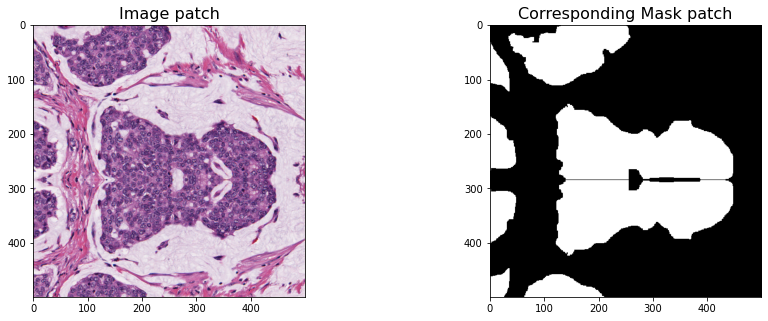

In [21]:
fig = Figure(figsize=(15,5))
fontsize=16
ax = fig.add_subplot(1,2,1)
i = random.randint(0, max_patches - 1)
ax.set_title('Image patch',fontsize=fontsize)
ax.imshow(original_out[i])

ax = fig.add_subplot(1,2,2)
ax.set_title('Corresponding Mask patch',fontsize=fontsize)
ax.imshow(mask_out[i])
fig

In [9]:
files=glob.glob(path+'/masks/*.png')#list containing filenames of all image files

phases={}
indices = list(model_selection.ShuffleSplit(n_splits=1,test_size=test_set_size).split(files))
phases["train"],phases["val"] = indices[0][0], indices[0][1]#get indices for train and test set

imgtypes=["img","mask"]

In [10]:
storage={}

block_shape={}
block_shape["img"]= np.array((patch_size,patch_size,3))
block_shape["mask"]= np.array((patch_size,patch_size)) 

filters=tables.Filters(complevel=6, complib='zlib')

for phase in phases.keys():
    print(phase)
    
    totals=np.zeros((2,len(classes)))
    totals[0,:]=classes

    hdf5_file = tables.open_file(f"{path}/{dataname}_{phase}.pytable", mode='w')
    storage["filename"] = hdf5_file.create_earray(hdf5_file.root, 'filename', filenameAtom, (0,)) 
    #earray: extendable array, means one doesn't have to specify size of array before righting to it

    for imgtype in imgtypes:
        storage[imgtype]= hdf5_file.create_earray(hdf5_file.root, imgtype, img_dtype,  
                                              shape=np.append([0],block_shape[imgtype]), 
                                              chunkshape=np.append([1],block_shape[imgtype]),
                                              filters=filters)
    for filei in phases[phase]: #now for each of the files
        fname=files[filei] 
        
        print(fname)

        imgtype = 'img'
        img_file = path+"/original/"+os.path.basename(fname).replace("_mask.png",".tif")
        io_arr_out = extract_patch(img_file, PIL.Image.BICUBIC)
        storage[imgtype].append(io_arr_out)

        imgtype = 'mask'
        io=cv2.imread(fname)/255 #the image is loaded as {0,255}, but we'd like to store it as {0,1} since this represents the binary nature of the mask easier

        for i,key in enumerate(classes): #sum the number of pixels, this is done pre-resize, but proportions don't change which is really what we're after
            totals[1,i]+=sum(sum(io[:,:,0]==key))

        io_arr_out = extract_patch(fname, PIL.Image.NEAREST)
        storage[imgtype].append(io_arr_out[:,:,:,0].squeeze()) #only need 1 channel for mask data
    
    storage["filename"].append([fname for x in range(io_arr_out.shape[0])]) #add the filename to the storage array
    #lastely, we should store the number of pixels
    npixels=hdf5_file.create_carray(hdf5_file.root, 'numpixels', tables.Atom.from_dtype(totals.dtype), totals.shape)
    npixels[:]=totals
    hdf5_file.close()

train
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12911_00005_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9043_00045_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10278_00006_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12947_00004_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10261_00002_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12626_00016_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12875_00002_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12881_00009_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/10286_00014_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12884_00018_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9023_00012_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/12819_00004_mask.png
/content/drive/MyDrive/dl_tutorial/epithelium/epi/masks/9227_00006_mask.